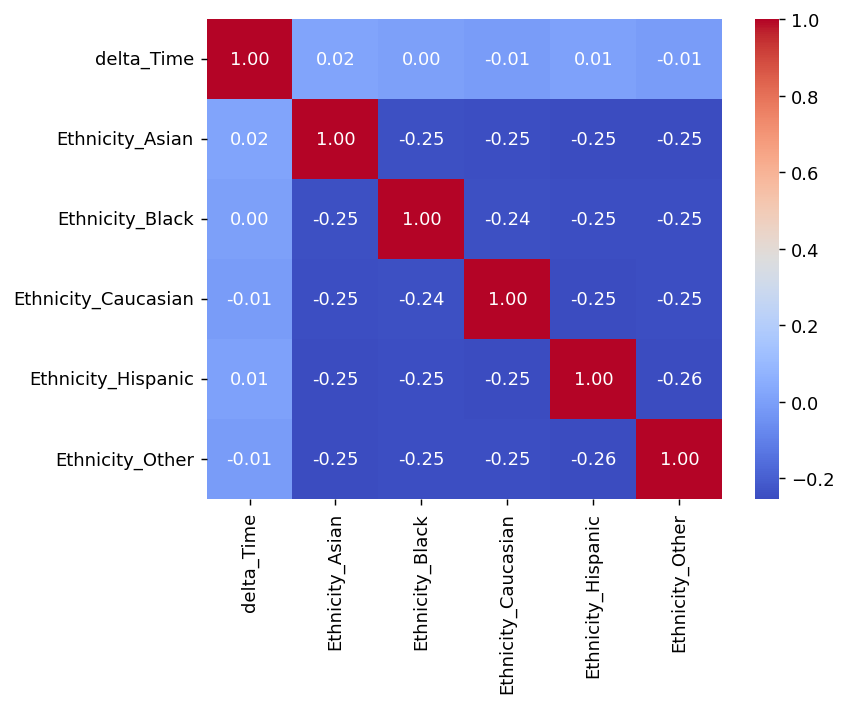

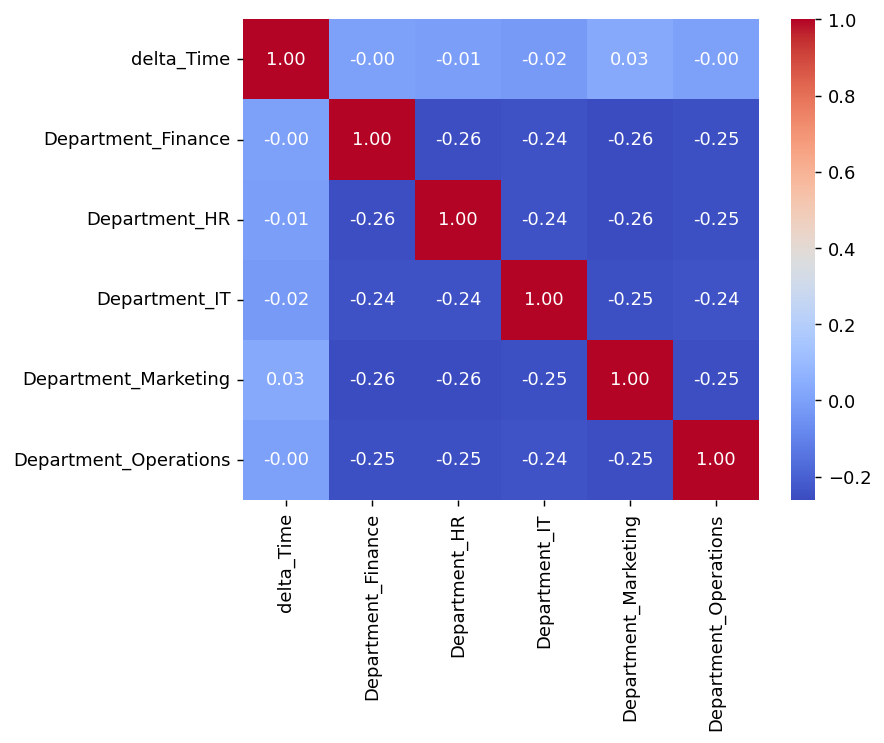

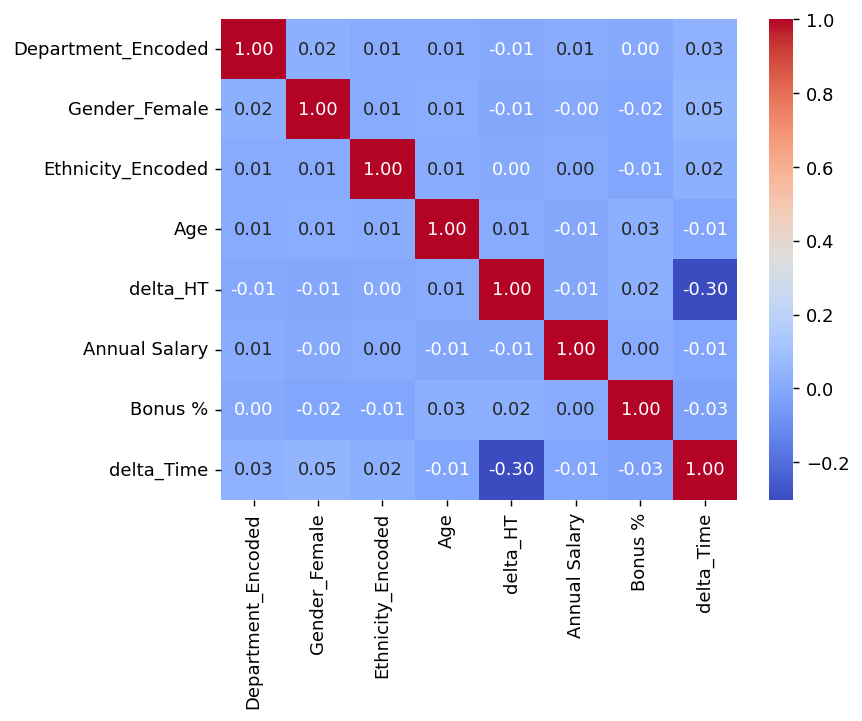

MAE: 788.1785762072767
RMSE: 923.4974747209362
Mean of delta time: 1838.1115


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import math

emp_IT=pd.read_csv('C:/Users/dawod/OneDrive/Desktop/Training/estarta/SQL/CSVs/Employee_Profile_IT.csv')
#Cleaning Data
#Fill in missing ages based
emp_IT.fillna({'Age':emp_IT.groupby(['Job Title'])['Age'].transform('mean')},inplace=True)
emp_IT['Age']=emp_IT['Age'].astype(int)

#fill in missing annual salary
emp_IT['Annual Salary']=emp_IT['Annual Salary'].str.replace('$','')
emp_IT['Annual Salary']=emp_IT['Annual Salary'].str.replace(' ','')
emp_IT['Annual Salary']=emp_IT['Annual Salary'].str.replace(',','')
emp_IT['Annual Salary']=emp_IT['Annual Salary'].astype(float)
emp_IT.fillna({'Annual Salary':emp_IT.groupby(['Job Title'])['Annual Salary'].transform('mean')},inplace=True)

#Fix format of hire date and exit date
emp_IT['Hire Date']=pd.to_datetime(emp_IT['Hire Date'],format='%Y-%m-%d')
emp_IT['Exit Date']=pd.to_datetime(emp_IT['Exit Date'],format='%Y-%m-%d')

#fill in missing hire dates
emp_IT.fillna({'Hire Date':emp_IT.groupby('Age')['Hire Date'].transform('mean')},inplace=True)

#Filling missing ethnicities based on names
emp_IT.loc[emp_IT['EEID'] == 'E00816', 'Ethnicity'] = 'Caucasian'
emp_IT.loc[emp_IT['EEID'] == 'E02855', 'Ethnicity'] = 'Asian'

#Fill in missing Ethnicity and Country based on each other
emp_IT.loc[emp_IT['Country'] == 'Brazil', 'Ethnicity'] = emp_IT.loc[emp_IT['Country'] == 'Brazil', 'Ethnicity'].fillna('Latino')
emp_IT.loc[emp_IT['Country'] == 'China', 'Ethnicity'] = emp_IT.loc[emp_IT['Country'] == 'China', 'Ethnicity'].fillna('Asian')
emp_IT.loc[(emp_IT['Ethnicity'] == 'Black') | (emp_IT['Ethnicity'] == 'Caucasian'),'Country'] = emp_IT.loc[(emp_IT['Ethnicity'] == 'Black') | (emp_IT['Ethnicity'] == 'Caucasian'),'Country'].fillna('United States')

#Fill in missing bonus through ethnicity, gender, and job title
emp_IT.fillna({'Bonus %':emp_IT.groupby(['Ethnicity','Job Title','Gender'])['Bonus %'].transform('mean')},inplace=True)

#Fill in missing city based on country, and ethnicity
emp_IT['City'] = emp_IT['City'].fillna(emp_IT.groupby(['Country', 'Ethnicity'])['City'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))

#Fill in missing Job Title based on ethnicity and annual salary
emp_IT.loc[emp_IT['EEID'] == 'E04116', 'Job Title'] = 'Director'

#Fix spelling mistakes in Job Titles
emp_IT['Job Title']=emp_IT['Job Title'].str.replace('Sr. Manger','Sr. Manager')
emp_IT['Job Title']=emp_IT['Job Title'].str.replace('System Administrator\xa0','System Administrator')

#Capitalize gender
emp_IT['Gender']=emp_IT['Gender'].str.capitalize()

#Data cleaned except missing names

#Dropping exit date column
emp_IT.drop(['Exit Date'],axis=1,inplace=True)

#Format exit and hire dates
emp_Exit=pd.read_csv('C:/Users/dawod/OneDrive/Desktop/Training/estarta/SQL/Task2_SQL_and_ML/Task 2/DATA/Employee_Exit.csv')
emp_Exit['Hire Date']=pd.to_datetime(emp_Exit['Hire Date'],format='%m/%d/%Y')
emp_Exit['Exit Date']=pd.to_datetime(emp_Exit['Exit Date'],format='%m/%d/%Y')

#Finding earliest hire date:
f_Date=min(emp_Exit['Hire Date'].min(),emp_IT['Hire Date'].min())
#Convert hire and exit dates into days employed to find the time an employee stayed at the company
emp_Exit['delta_Time']=pd.Series((emp_Exit['Exit Date']-emp_Exit['Hire Date'])/np.timedelta64(1,'D'))
emp_Exit['delta_HT']=pd.Series((emp_Exit['Hire Date']-f_Date)/np.timedelta64(1,'D'))

#Fix formatting of annual salary and bonus % so it can be chagned to float
emp_Exit['Annual Salary']=emp_Exit['Annual Salary'].str.replace('$','')
emp_Exit['Annual Salary']=emp_Exit['Annual Salary'].str.replace(',','')
emp_Exit['Annual Salary']=emp_Exit['Annual Salary'].astype(float)
emp_Exit['Bonus %']=emp_Exit['Bonus %'].str.replace('%','')
emp_Exit['Bonus %']=emp_Exit['Bonus %'].astype(float)

#Removing the outliers (in this case removed because we want to use all of the entries):
#q1, q3 = np.percentile(emp_Exit['delta_Time'], [25, 75])
#iqr = q3 - q1
#lower = q1 - 1.5 * iqr
#upper = q3 + 1.5 * iqr
c_Exit = emp_Exit

#Checking correlation for ethnicities
corr = pd.get_dummies(c_Exit[['Ethnicity','delta_Time']],columns=['Ethnicity']).corr()
plt.figure(dpi=130)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

#Checking correlation for departments
corr = pd.get_dummies(c_Exit[['Department','delta_Time']],columns=['Department']).corr()
plt.figure(dpi=130)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

#Encoding ethnicity, department and gender based on their correlation with delta_Time
c_Exit['Ethnicity_Encoded']=c_Exit['Ethnicity'].map({'Caucasian':0,'Other':0,'Black':1,'Hispanic':2,'Asian':3})
c_Exit['Department_Encoded']=c_Exit['Department'].map({'IT':0,'HR':1,'Operations':2,'Finance':2,'Marketing':3})
c_Exit=pd.get_dummies(c_Exit,columns=['Gender'])

#Setting the X and Y data, taking only the data for IT department since that is the department we are trying to predict the exit dates for
X=c_Exit[['Department_Encoded','Gender_Female','Ethnicity_Encoded','Age','delta_HT','Annual Salary','Bonus %']]
y=c_Exit[['delta_Time']]

#Checking correlation
corr = c_Exit[['Department_Encoded','Gender_Female','Ethnicity_Encoded','Age','delta_HT','Annual Salary','Bonus %','delta_Time']].corr()
plt.figure(dpi=130)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

#Seperating training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=35)

#Train the model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error

#Find the mae and rmse
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred)

print("MAE:",mae)
print("RMSE:",math.sqrt(rmse))
print("Mean of delta time:",(c_Exit['delta_Time']).mean())

#Filling in temporary columns
#Encoding ethnicity, department and gender based on their correlation with delta_Time according to the training data
emp_IT['Ethnicity_Encoded']=emp_IT['Ethnicity'].map({'Caucasian':0,'Black':1,'Latino':2,'Asian':3})
emp_IT['Department_Encoded']=emp_IT['Department'].map({'IT':0,'HR':1,'Operations':2,'Finance':2,'Marketing':3})
emp_IT=pd.get_dummies(emp_IT,columns=['Gender'])
emp_IT['delta_HT']=pd.Series((emp_Exit['Hire Date']-f_Date)/np.timedelta64(1,'D'))

#Using model to predict exit dates for employees
emp_IT['Predicted Exit Date'] = emp_IT['Hire Date'] + pd.to_timedelta(model.predict(emp_IT[['Department_Encoded','Gender_Female','Ethnicity_Encoded','Age','delta_HT','Annual Salary','Bonus %']]).flatten(),unit='D')

#Dropping temporary columns
emp_IT.drop(['delta_HT'],axis=1,inplace=True)
emp_IT.drop(['Ethnicity_Encoded'],axis=1,inplace=True)
emp_IT.drop(['Department_Encoded'],axis=1,inplace=True)
emp_IT.drop(['Gender_Male'],axis=1,inplace=True)
emp_IT.drop(['Gender_Female'],axis=1,inplace=True)

# Show the predicted data
#print(emp_IT[['EEID','Predicted Exit Date']].to_string())